# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

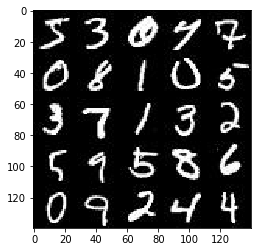

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

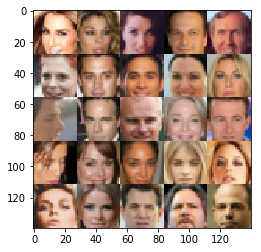

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Various utility methods and variables for use in making generator and discriminator
generator_name = 'generator'
discriminator_name = 'discriminator'

def batch_normalize_lrelu(x, alpha, training=True):
    x = tf.layers.batch_normalization(x, training=training)
    x = tf.maximum(alpha * x, x)
    return x

def generator_input_layer(z, filters, kernel_size, alpha=0.2, training=True):    
    unit_count = kernel_size * kernel_size * filters
    x = tf.layers.dense(z, unit_count)
    x = tf.reshape(x, (-1, kernel_size, kernel_size, filters))
    x = batch_normalize_lrelu(x, alpha, training)
    return x

def generator_conv2d_transpose(x, filters, kernel_size, alpha=0.2, training=True):
    x = tf.layers.conv2d_transpose(x, filters, kernel_size, strides=2, padding='same')
    x = batch_normalize_lrelu(x, alpha, training)
    return x

def discriminator_conv2d(x, filters, kernel_size, alpha=0.2, training=True):
    x = tf.layers.conv2d(x, filters, kernel_size, strides=2, padding='same')
    x = batch_normalize_lrelu(x, alpha, training)
    return x

## Project Note

I doubled the depth at each convolution layer compared to previous MNIST of SVHN examples in hope of better capturing the information in faces.

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope(discriminator_name, reuse=reuse):
        # Input layer is 28x28x3
        x = discriminator_conv2d(images, 128, 5, alpha=alpha)
        # Shape now 14x14x64
        x = discriminator_conv2d(x, 256, 5, alpha=alpha)       
        # Shape now 7x7x128
        x = discriminator_conv2d(x, 512, 5, alpha=alpha)
        # Shape now 4x4x256
        
        flat = tf.reshape(x, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope(generator_name, reuse=not is_train):
        # First fully connected layer
        x = generator_input_layer(z, 512, 4, alpha=alpha, training=is_train)
        # Shape is now 4x4x512
        
        # Convolutional layers
        x = generator_conv2d_transpose(x, 512, 5, alpha=alpha, training=is_train)
        # Shape is now 8x8x256 
        x = generator_conv2d_transpose(x, 256, 5, alpha=alpha, training=is_train)
        # Shape is now 16x16x128
       
        # Output layer, 32x32x3
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        
        # Resize to 28x28
        logits = tf.image.resize_nearest_neighbor(x, [28, 28])
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
class GAN:
    def __init__(self, width, height, channels, z_size, learning_rate, alpha=0.2, beta1=0.5):
        # tf.reset_default_graph()
        
        self.input_real, self.input_z, _ = model_inputs(width, height, channels, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, channels, alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)



## Project Note


Generator losses stop decreasing after a while, even with a very low learning rate (0.00001 in my case).  In addition to showing images every 100 iterations, I added a parameter *step_threshold* which will stop the whole process after that step count if the generator loss dip below the *gen_loss_threshold* parameter.

I also doubled the batch_images data to stretch the value range from -0.5 through 0.5 to -1 through 1 to better match the range of tanh output in the generator.  There were discussions in the forum about how this would improve image generation quality which seems intuitive.

In [85]:
import pickle as pkl

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, \
          step_threshold=0, gen_loss_threshold=0.5):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    :param stop_threshold: If non-zero, stop when generator loss is less than discriminator loss
    """
    # TODO: Build Model
    width = data_shape[1]
    height = data_shape[2]
    channels = data_shape[3]
    
    net = GAN(width, height, channels, z_dim, learning_rate, beta1=beta1)
    
    show_every = 300
    print_every = 60
    images_to_show = 12
    steps = 0
    samples = []
    losses = []

    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model                
                steps += 1

                # Set the range of pixel values to between -1 and 1 to better match with tanh output
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                # At each step get the losses
                train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                if steps % print_every == 0:

                    print("Step {} in Epoch {}/{}...".format(steps, epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = show_generator_output(sess, images_to_show, net.input_z, channels, \
                        data_image_mode)
                    samples.append(gen_samples)
                
                if step_threshold > 0 and steps > step_threshold and train_loss_g < gen_loss_threshold:
                    print("Final Step {} in Epoch {}/{}...".format(steps, epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    gen_samples = show_generator_output(sess, images_to_show, net.input_z, channels, \
                        data_image_mode)
                    samples.append(gen_samples)
                    break

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)    
    
    return samples, losses

## Project Note

Noticed that losses were bouncing around a lot at initial learning rate of 0.0002, varying by as much as 10 to 20 even in later training, so experimented lowering the learning rate, first to 0.00005, and then to 0.00001, and then back up to 0.00002.

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 60 in Epoch 1/2... Discriminator Loss: 0.0551... Generator Loss: 8.6320
Step 120 in Epoch 1/2... Discriminator Loss: 0.3763... Generator Loss: 3.3924
Step 180 in Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.2276
Step 240 in Epoch 1/2... Discriminator Loss: 2.3766... Generator Loss: 0.2535
Step 300 in Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.3959


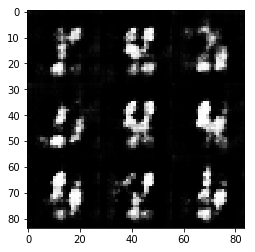

Step 360 in Epoch 1/2... Discriminator Loss: 0.4573... Generator Loss: 1.8901
Step 420 in Epoch 1/2... Discriminator Loss: 0.7580... Generator Loss: 0.8948
Step 480 in Epoch 1/2... Discriminator Loss: 1.7414... Generator Loss: 0.2700
Step 540 in Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.7379
Step 600 in Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.2499


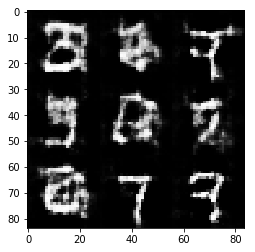

Step 660 in Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.5826
Step 720 in Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 1.2834
Step 780 in Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 2.0039
Step 840 in Epoch 1/2... Discriminator Loss: 0.5363... Generator Loss: 1.4689
Step 900 in Epoch 1/2... Discriminator Loss: 0.4637... Generator Loss: 1.5806


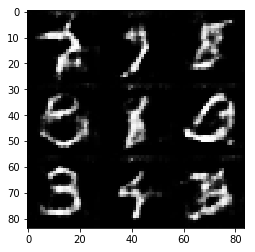

Step 960 in Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 1.6588
Step 1020 in Epoch 1/2... Discriminator Loss: 0.7256... Generator Loss: 1.2201
Step 1080 in Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 0.7596
Step 1140 in Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 1.1007
Step 1200 in Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 1.1308


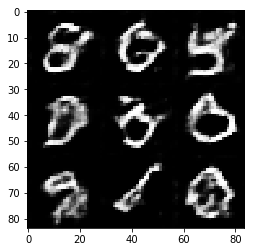

Step 1260 in Epoch 1/2... Discriminator Loss: 0.5602... Generator Loss: 1.7149
Step 1320 in Epoch 1/2... Discriminator Loss: 1.3372... Generator Loss: 0.4497
Step 1380 in Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 1.3480
Step 1440 in Epoch 1/2... Discriminator Loss: 0.7236... Generator Loss: 1.2921
Step 1500 in Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 0.9797


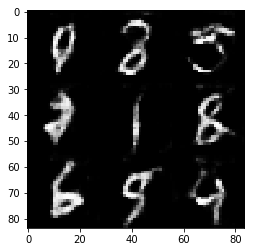

Step 1560 in Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 0.8619
Step 1620 in Epoch 1/2... Discriminator Loss: 0.7152... Generator Loss: 1.0000
Step 1680 in Epoch 1/2... Discriminator Loss: 0.3461... Generator Loss: 1.6276
Step 1740 in Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 2.3956
Step 1800 in Epoch 1/2... Discriminator Loss: 0.4423... Generator Loss: 1.6712


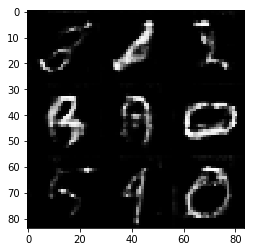

Step 1860 in Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.3443
Step 1920 in Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.1691
Step 1980 in Epoch 2/2... Discriminator Loss: 0.6173... Generator Loss: 1.3179
Step 2040 in Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 1.2087
Step 2100 in Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 1.8468


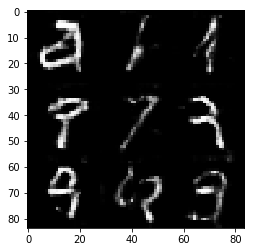

Step 2160 in Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 1.7514
Step 2220 in Epoch 2/2... Discriminator Loss: 0.5651... Generator Loss: 2.3916
Step 2280 in Epoch 2/2... Discriminator Loss: 0.6139... Generator Loss: 1.0790
Step 2340 in Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 1.0259
Step 2400 in Epoch 2/2... Discriminator Loss: 0.4795... Generator Loss: 1.3652


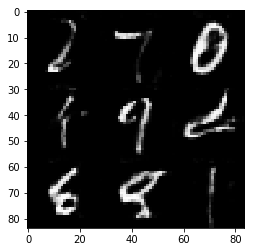

Step 2460 in Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 0.8342
Step 2520 in Epoch 2/2... Discriminator Loss: 0.5050... Generator Loss: 1.3689
Step 2580 in Epoch 2/2... Discriminator Loss: 0.6506... Generator Loss: 1.1162
Step 2640 in Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.7337
Step 2700 in Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.2934


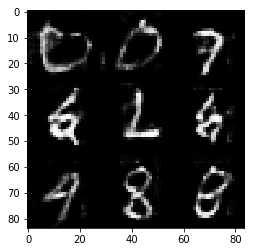

Step 2760 in Epoch 2/2... Discriminator Loss: 0.3095... Generator Loss: 1.8742
Step 2820 in Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.9403
Step 2880 in Epoch 2/2... Discriminator Loss: 0.3565... Generator Loss: 1.8057
Step 2940 in Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 1.4141
Step 3000 in Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 1.3863


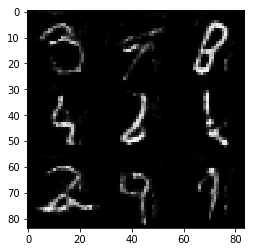

Step 3060 in Epoch 2/2... Discriminator Loss: 0.3466... Generator Loss: 1.6718
Step 3120 in Epoch 2/2... Discriminator Loss: 0.2185... Generator Loss: 2.5555
Step 3180 in Epoch 2/2... Discriminator Loss: 0.6736... Generator Loss: 0.9805
Step 3240 in Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 3.8923
Step 3300 in Epoch 2/2... Discriminator Loss: 0.4708... Generator Loss: 1.5637


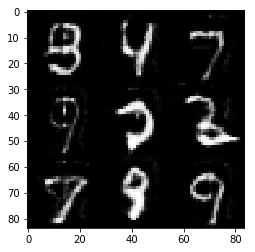

Final Step 3304 in Epoch 2/2... Discriminator Loss: 1.9588... Generator Loss: 0.2372


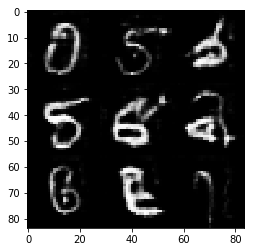

Done training


In [87]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    samples, losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, step_threshold=3300, gen_loss_threshold=0.5)
    print("Done training")

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 60 in Epoch 1/1... Discriminator Loss: 0.1736... Generator Loss: 2.3552
Step 120 in Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 2.9881
Step 180 in Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 2.9950
Step 240 in Epoch 1/1... Discriminator Loss: 0.0939... Generator Loss: 3.0226
Step 300 in Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 2.9042


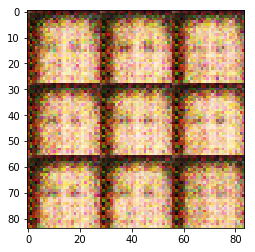

Step 360 in Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 3.9976
Step 420 in Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 2.1895
Step 480 in Epoch 1/1... Discriminator Loss: 0.3206... Generator Loss: 1.9682
Step 540 in Epoch 1/1... Discriminator Loss: 0.2492... Generator Loss: 2.1150
Step 600 in Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.7508


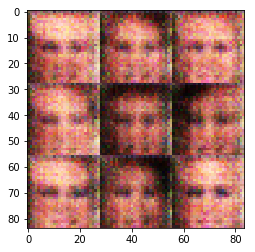

Step 660 in Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 1.9752
Step 720 in Epoch 1/1... Discriminator Loss: 0.2761... Generator Loss: 3.5817
Step 780 in Epoch 1/1... Discriminator Loss: 0.1621... Generator Loss: 2.6909
Step 840 in Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 2.2544
Step 900 in Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 1.9703


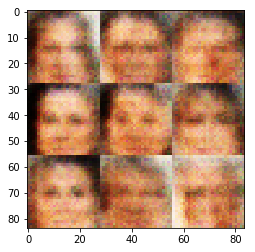

Step 960 in Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.4572
Step 1020 in Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 1.5453
Step 1080 in Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 1.6656
Step 1140 in Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 1.7790
Step 1200 in Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 2.1990


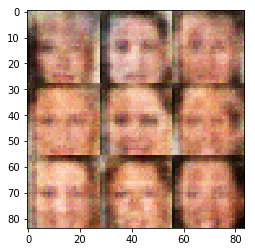

Step 1260 in Epoch 1/1... Discriminator Loss: 0.2702... Generator Loss: 2.9164
Step 1320 in Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 1.7238
Step 1380 in Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 2.0023
Step 1440 in Epoch 1/1... Discriminator Loss: 0.2758... Generator Loss: 2.3409
Step 1500 in Epoch 1/1... Discriminator Loss: 0.2217... Generator Loss: 3.5600


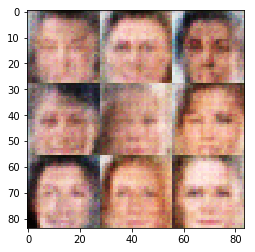

Step 1560 in Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 2.2477
Step 1620 in Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 2.4360
Step 1680 in Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 1.5008
Step 1740 in Epoch 1/1... Discriminator Loss: 0.5010... Generator Loss: 1.4867
Step 1800 in Epoch 1/1... Discriminator Loss: 0.3239... Generator Loss: 2.5293


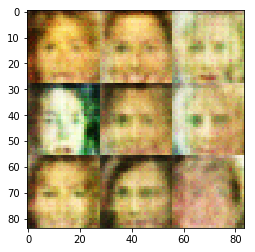

Step 1860 in Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 2.0824
Step 1920 in Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 2.1459
Step 1980 in Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.4988
Step 2040 in Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.1847
Step 2100 in Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 0.7431


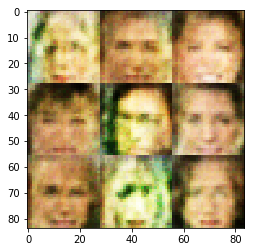

Step 2160 in Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 1.8455
Step 2220 in Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.1169
Step 2280 in Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.8668
Step 2340 in Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.2253
Step 2400 in Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 2.1124


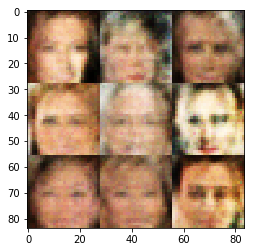

Step 2460 in Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 0.8177
Step 2520 in Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 1.9534
Step 2580 in Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 1.7178
Step 2640 in Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.5603
Step 2700 in Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 1.5887


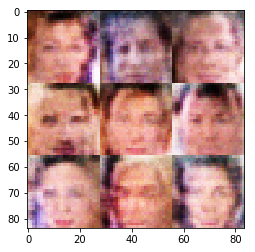

Step 2760 in Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 0.9906
Step 2820 in Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 1.4469
Step 2880 in Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 1.1618
Step 2940 in Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.7934
Step 3000 in Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 1.4972


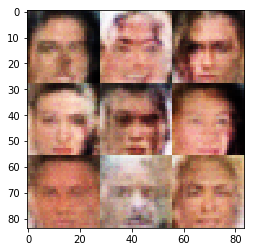

Step 3060 in Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.1351
Step 3120 in Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 1.1374
Step 3180 in Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 1.5485
Step 3240 in Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 1.8362
Step 3300 in Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 1.7889


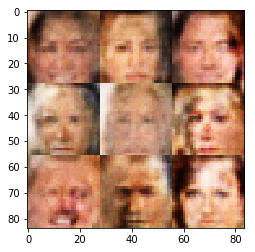

Step 3360 in Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 1.7950
Step 3420 in Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 1.5194
Step 3480 in Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.1742
Step 3540 in Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.3637
Step 3600 in Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 1.4118


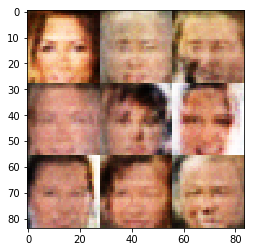

Step 3660 in Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.4929
Step 3720 in Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.3054
Step 3780 in Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 1.2701
Step 3840 in Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 0.7664
Step 3900 in Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 1.9603


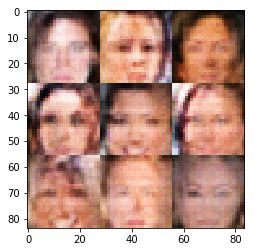

Step 3960 in Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 1.1664
Step 4020 in Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.1255
Step 4080 in Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 1.7772
Step 4140 in Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 1.5838
Step 4200 in Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 1.6988


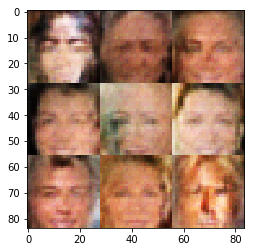

Step 4260 in Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 1.9842
Step 4320 in Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 1.7186
Step 4380 in Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.1128
Step 4440 in Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 1.5040
Step 4500 in Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.6929


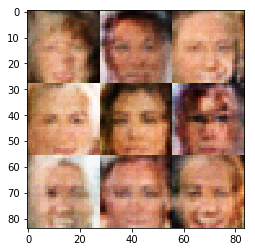

Step 4560 in Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 0.9260
Step 4620 in Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 1.8267
Step 4680 in Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 1.6307
Step 4740 in Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 0.9511
Step 4800 in Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 2.2221


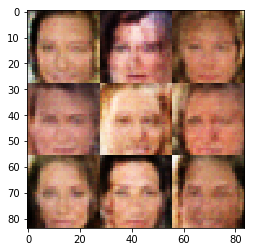

Step 4860 in Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 1.4771
Step 4920 in Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 0.9504
Step 4980 in Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 1.9441
Step 5040 in Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.1162
Step 5100 in Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 0.7617


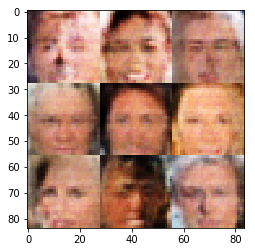

Final Step 5155 in Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.4331


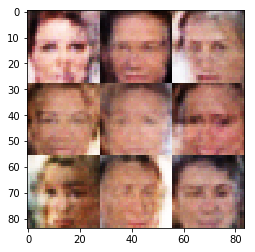

In [88]:
batch_size = 32
z_dim = 100
learning_rate = 0.00002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, step_threshold=5000, gen_loss_threshold=0.5)

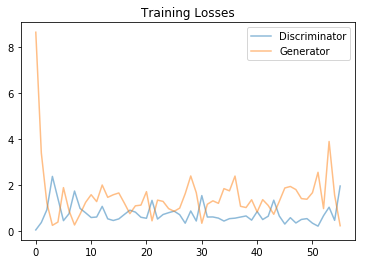

In [89]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.